In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder_kde"

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

100%|██████████| 9912422/9912422 [00:00<00:00, 190276113.01it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 30520457.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71804179.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19823651.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



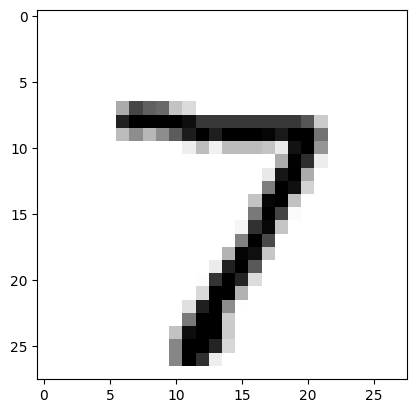

Image size torch.Size([1, 28, 28])
Label 7


In [ ]:
dataset = MNIST(root="./", train=False, download=True, transform=ToTensor())
image, label = dataset.__getitem__(0)
plt.imshow(image.squeeze(0),cmap="binary")
plt.show()
print("Image size", image.shape)
print("Label", label)

In [ ]:
BATCH_SIZE = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [ ]:
dataloader_whole = DataLoader(dataset, batch_size=10000, shuffle=False, num_workers=os.cpu_count())
NUM_LABELS = 10
labelixs = {}
for _,label in dataloader_whole:

  for i in range(NUM_LABELS):
    labelixs[i] = label == i




In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
class cnnblock(nn.Module):

  def __init__(self, input_cha, output_cha, size, activation = "tanh", stride = 2, padding=1):
    super().__init__()

    if activation=="tanh":
      self.model = nn.Sequential(
          nn.Conv2d(input_cha, output_cha, size, bias=False, stride=stride, padding=1),
          nn.BatchNorm2d((output_cha)),
          nn.Tanh()
      )
    else:
      self.model = nn.Sequential(
          nn.Conv2d(input_cha, output_cha, size, bias=False, stride=stride, padding=1),
          nn.BatchNorm2d((output_cha)),
          nn.ReLU()
      )

  def forward(self, x):
        y = self.model(x)
        return y


class cnn(nn.Module):

   def __init__(self, activation):
    super().__init__()
    self.p = nn.ZeroPad2d(2)
    self.l1 = cnnblock(1, 4, 2, activation, stride = 1)
    self.l2 = cnnblock(4, 6, 2, activation, stride = 1)
    self.l3 = cnnblock(6, 12, 1, activation)
    self.l4 = cnnblock(12, 24, 1, activation)
    self.av = nn.AvgPool2d((3,3))
    self.flat = nn.Flatten()
    self.lin = nn.Linear(in_features=216, out_features=10)
    self.sig = nn.Sigmoid()
   def forward(self,input):
    input = self.p(input)
    l1 = self.l1(input)
    l2 = self.l2(l1)
    l3 = self.l3(l2)
    l4 = self.l4(l3)
    av = self.av(l4)
    flat = self.flat(av)
    lin = self.lin(flat)
    sig = self.sig(lin)
    return sig,l1,l2,l3,l4

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
cnn_tanh = cnn("tanh").to(device)
cnn_tanh.apply(weights_init)

cnn(
  (p): ZeroPad2d((2, 2, 2, 2))
  (l1): cnnblock(
    (model): Sequential(
      (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
  )
  (l2): cnnblock(
    (model): Sequential(
      (0): Conv2d(4, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
  )
  (l3): cnnblock(
    (model): Sequential(
      (0): Conv2d(6, 12, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
  )
  (l4): cnnblock(
    (model): Sequential(
      (0): Conv2d(12, 24, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
from torchsummary import summary
summary(cnn_tanh,input_size = (1, 28, 28), batch_size = 100,device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1           [100, 1, 32, 32]               0
            Conv2d-2           [100, 4, 33, 33]              16
       BatchNorm2d-3           [100, 4, 33, 33]               8
              Tanh-4           [100, 4, 33, 33]               0
          cnnblock-5           [100, 4, 33, 33]               0
            Conv2d-6           [100, 6, 34, 34]              96
       BatchNorm2d-7           [100, 6, 34, 34]              12
              Tanh-8           [100, 6, 34, 34]               0
          cnnblock-9           [100, 6, 34, 34]               0
           Conv2d-10          [100, 12, 18, 18]              72
      BatchNorm2d-11          [100, 12, 18, 18]              24
             Tanh-12          [100, 12, 18, 18]               0
         cnnblock-13          [100, 12, 18, 18]               0
           Conv2d-14          [100, 24,

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
opt= torch.optim.SGD(cnn_tanh.parameters(), lr=0.01, momentum=0.9)


In [ ]:
def train_step(images, label, cnn, BATCH_SIZE, opt):

    prob,l1_out,l2_out,l3_out,l4_out = cnn(images)
    cnn_loss = loss(prob, label.to(device))
    opt.zero_grad()
    cnn_loss.backward()
    opt.step()
    return cnn_loss, prob,l1_out,l2_out,l3_out,l4_out


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np
import scipy.special as sp


def get_dists(X):
    """code to compute the pairwise distance matrix for a set of
    vectors specifie by the matrix X.
    """
    x2 = (X**2).sum(axis=1)[:,None]
    dists = x2 + x2.T - 2*X.dot(X.T)
    return dists

def get_shape(x):
    dims = float(x.shape[1])
    N    = float(x.shape[0])
    return dims, N

def entropy_estimator_kl(x, var):
    # KL-based upper bound on entropy of mixture of Gaussians with covariance matrix var * I
    #  see Kolchinsky and Tracey, Estimating Mixture Entropy with Pairwise Distances, Entropy, 2017. Section 4.
    #  and Kolchinsky and Tracey, Nonlinear Information Bottleneck, 2017. Eq. 10
    dims, N = get_shape(x)
    dists = get_dists(x)
    dists2 = dists / (2*var)
    normconst = (dims / 2.0)*np.log(2*np.pi*var)
    lprobs = sp.logsumexp(-dists2, axis=1) - np.log(N) - normconst
    h = -np.mean(lprobs)
    return dims/2 + h

def entropy_estimator_bd(x, var):
    # Bhattacharyya-based lower bound on entropy of mixture of Gaussians with covariance matrix var * I
    #  see Kolchinsky and Tracey, Estimating Mixture Entropy with Pairwise Distances, Entropy, 2017. Section 4.
    dims, N = get_shape(x)
    val = entropy_estimator_kl(x, 4*var)
    return val + np.log(0.25)*dims / 2

def kde_condentropy(output, var):
    # Return entropy of a multivariate Gaussian, in nats
    dims = output.shape[1]
    return (dims / 2.0) * (np.log(2 * np.pi * var) + 1)

In [ ]:

mi_data = {0: {"x_u":[],"y_u":[],"x_l":[],"y_l":[],"h_l":[],"h_u":[]}, 1: {"x_u":[],"y_u":[],"x_l":[],"y_l":[],"h_l":[],"h_u":[]},
           2: {"x_u":[],"y_u":[],"x_l":[],"y_l":[],"h_l":[],"h_u":[]}, 3: {"x_u":[],"y_u":[],"x_l":[],"y_l":[],"h_l":[],"h_u":[]}}

activities = [np.zeros((10000, 4, 33,33)),
              np.zeros((10000, 6, 34,34)),
              np.zeros((10000 ,12, 18,18)),
              np.zeros((10000 ,24, 10,10))]

for layer_no in range(4):
    mi_data[layer_no]['full'] = []
    for f in range(activities[layer_no].shape[1]):
        mi_data[layer_no][f'F{f + 1}'] = []

def train(dataloader, epochs, cnn, BATCH_SIZE, opt):
  loss_list = []
  acc_list = []
  for epoch in range(epochs):
    losses = []
    conc_out = []
    conc_label = []
    i=0
    print(epoch)
    for image_batch, label in dataloader:
        image_batch = image_batch.to(device)
        cnn_loss, prob,l1_out,l2_out,l3_out,l4_out = train_step(image_batch,label, cnn, BATCH_SIZE, opt)
        for num in range(100):
            activities[0][num+i]=l1_out[num].detach().cpu().numpy()
            activities[1][num+i]=l2_out[num].detach().cpu().numpy()
            activities[2][num+i]=l3_out[num].detach().cpu().numpy()
            activities[3][num+i]=l4_out[num].detach().cpu().numpy()

        i+=100
        losses.append(cnn_loss.detach().cpu().item())
        conc_out.append(prob.detach().cpu())
        conc_label.append(label.detach().cpu())

    for idx, layer in enumerate(activities):
        layer_full = np.array([layer[fn].flatten() for fn in range(len(layer))])
        H_up = entropy_estimator_kl(layer_full, 1e-1)
        H_lo = entropy_estimator_bd(layer_full, 1e-1)

        H_T_X = kde_condentropy(layer_full, 1e-1)

        H_Y_T_up = 0
        H_Y_T_lo = 0
        for label, ixs in labelixs.items():
          b = ixs.long()
          b = np.array(b)
          H_Y_T_up += b.mean() * entropy_estimator_kl(layer_full[ixs, :], 1e-1)
          H_Y_T_lo += b.mean() * entropy_estimator_bd(layer_full[ixs, :], 1e-1)

        mi_data[idx]['x_u'].append((1.0/np.log(2)) * (H_up - H_T_X))
        mi_data[idx]['y_u'].append((1.0/np.log(2)) * (H_up - H_Y_T_up))

        mi_data[idx]['x_l'].append((1.0/np.log(2)) * (H_lo - H_T_X))
        mi_data[idx]['y_l'].append((1.0/np.log(2)) * (H_lo - H_Y_T_lo))

        mi_data[idx]['h_u'].append((1.0/np.log(2))* H_up / layer_full.shape[1] )
        mi_data[idx]['h_l'].append((1.0/np.log(2))* H_lo / layer_full.shape[1] )


    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)
    acc = accuracy_score(conc_label, conc_out.argmax(axis=1))
    loss_list.append(np.mean(losses))
    acc_list.append(acc)
  return loss_list , acc_list

In [ ]:
epochs=250
loss_list, acc_list = train(dataloader,epochs, cnn_tanh, BATCH_SIZE, opt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
